# Surface geostrophic velocities calculated from sea level

This recipe uses sea level ($\eta$) to calculate surface geostrophic velocities ($\mathbf{u}$) using the following relation:

$$
\mathbf{u} = \frac{g}{f} \mathbf{\hat{z}} \times \nabla \eta
$$

This recipe works with MOM5, but instructions to adapt for MOM6 are given below.

#### Adapting for MOM6

|Variable | MOM5 diagnostic | Equivalent MOM6 diagnostic | 
|:--------|-----|------|
| Sea level (m) | `sea_level` | `zos` | 
| Horizontal velocities (m/s) | `u`,`v` | `uo`,`vo` | 

In MOM5 velocities are calculated in the (north-east) corner of the cells, where the dimension names are `xu_ocean` and `yu_ocean`. In MOM6, velocities are calculated in the eastern face of the cell for `uo` and northern face of the cell for `vo`. To adapt this recipe, an option would be to interpolate first `uo` and `vo` to be in the (north-east) corner, where the dimensions are (`xq`, `yq`). For more information on grids and `xgcm`, refer to [INSERT UPCOMING TUTORIAL ON GRIDS]. 

There are a few different options for the zonal and meridional lengths of the cells as well, which you can use depending on how you perform the `xgcm` interpolation and differentiation. 

In [1]:
import intake

from dask.distributed import Client

import xarray as xr
import numpy as np 

import xgcm
import gsw 

import matplotlib.pyplot as plt
import cmocean as cm

In [2]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34665,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43309,Total threads: 1
Dashboard: /proxy/40225/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42439,


## Load ACCESS OM-2 interannual forcing simulation

Load ACCESS-NRI default catalog

In [3]:
catalog = intake.cat.access_nri

Load model variables needed. We will only load one month of daily data, and we will select a subset over a Subantarctic Front meander in the Antarctic Circumpolar Current.

In [30]:
experiment = '01deg_jra55v140_iaf'
dates = '1997-04.*'
freq = '1day'

cat_subset = catalog[experiment]

def select_region(ds):
    ds = ds.sel(xt_ocean=slice(-224.2, -212.0), yt_ocean=slice(-53.5,  -47.5))
    return ds

# Load sea level 
darray = cat_subset.search(variable='sea_level', frequency=freq, start_date=dates).to_dask(preprocess=select_region)
sea_level = darray['sea_level']

def select_region(ds):
    ds = ds.isel(st_ocean=0).sel(xu_ocean=slice(-224.2, -212.0), yu_ocean=slice(-53.5,  -47.5))
    return ds

# Load diagnosed velocities (to compare to geostrophic velocities)
darray = cat_subset.search(variable='u', frequency=freq, start_date=dates).to_dask(preprocess=select_region)
u = darray['u']
darray = cat_subset.search(variable='v', frequency=freq, start_date=dates).to_dask(preprocess=select_region)
v = darray['v']

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

Load grid coordinates and sizes.

In [46]:
# Load coordinates and grid specifications
darray = cat_subset.search(variable=['dxu'], frequency='fx').to_dask()
dxu = darray['dxu'].sel(xu_ocean=slice(-224.2, -212.0), yu_ocean=slice(-53.5,  -47.5))
darray = cat_subset.search(variable=['dyu'], frequency='fx').to_dask()
dyu = darray['dyu'].sel(xu_ocean=slice(-224.2, -212.0), yu_ocean=slice(-53.5,  -47.5))

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  reco

## Define an Arakawa B staggered grid with `xgcm`

The way `xgcm` works is that we first create a `grid` object that has all the information regarding our staggered grid. For our case, `grid` needs to know the location of the `xt_ocean`, `xu_ocean` points (and same for y) and their relative orientation to one another, i.e., that `xu_ocean` is shifted to the right of `xt_ocean` by $\frac{1}{2}$ grid-cell.

In [47]:
ds = xr.merge([dxu, dyu, sea_level, u, v])

ds.coords['xt_ocean'].attrs.update(axis='X')
ds.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5)
ds.coords['yt_ocean'].attrs.update(axis='Y')
ds.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)

grid = xgcm.Grid(ds, boundary='extend')
grid

<xgcm.Grid>
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

## Calculate geostrophic velocities

The geostrophic velocities at the surface can be calculated from sea level contours. This can be done from satellite altimetry by using the SSH contours or in the ACCESS-OM2 simulation by using the sea level contours. The relation between the surface geostrophic zonal ($u_{g,s}$) and meridional ($v_{g,s}$) velocities and the sea level ($\eta$) are as follow:

$$
    u_{g,s} = -\frac{g}{f}\frac{\partial \eta}{\partial y} \quad \textrm{and} \quad
    v_{g,s} = \frac{g}{f}\frac{\partial \eta}{\partial x}
$$

where $g$ is the gravitational acceleration and $f$ is the Coriolis parameter. Let's calculate these two first:

In [48]:
pressure = gsw.p_from_z(-u['st_ocean'], u['yu_ocean'])
f = gsw.f(u['yu_ocean'])
g = gsw.grav(u['yu_ocean'], pressure)

Now we are ready to calculate the geostrophic velocities:

In [49]:
# Sea level horizontal gradients
detadx = grid.interp(grid.diff(ds['sea_level'], 'X', boundary='extend'), 'Y', boundary='extend') / ds['dxu']
detady = grid.interp(grid.diff(ds['sea_level'], 'Y', boundary='extend'), 'X', boundary='extend') / ds['dyu']

ds['ug_s'] = - (g / f) * detady
ds['ug_s'].name = 'ug_s'
ds['ug_s'].attrs['standard_name'] = 'surface_geostrophic_eastward_sea_water_velocity'
ds['ug_s'].attrs['long_name'] = r'$u_g,s$'
ds['ug_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'

ds['vg_s'] =   (g / f) * detadx
ds['vg_s'].name = 'vg_s'
ds['vg_s'].attrs['standard_name'] = 'surface_geostrophic_northward_sea_water_velocity'
ds['vg_s'].attrs['long_name'] = r'$v_g,s$'
ds['vg_s'].attrs['units'] = r'$\mathrm{ms}^{-1}$'

Now, we just have to provide the function `geostrophic_velocity` with the variables in the Dataset, the Grid made with `xgcm`, we set stream_func to None, because we only calculate the geostrophic velocities at the surface and we provide the names of $dx$ and $dy$ in the Dataset.

In [50]:
# calculating the geostrophic flow speed
Vg = np.sqrt(ds['ug_s']**2 + ds['vg_s']**2)

We have now calculated the geostrophic velocities and we can make a plot, in which we show the geostrophic flow speed averaged over the 16-day period with the sea level contours overlaid.

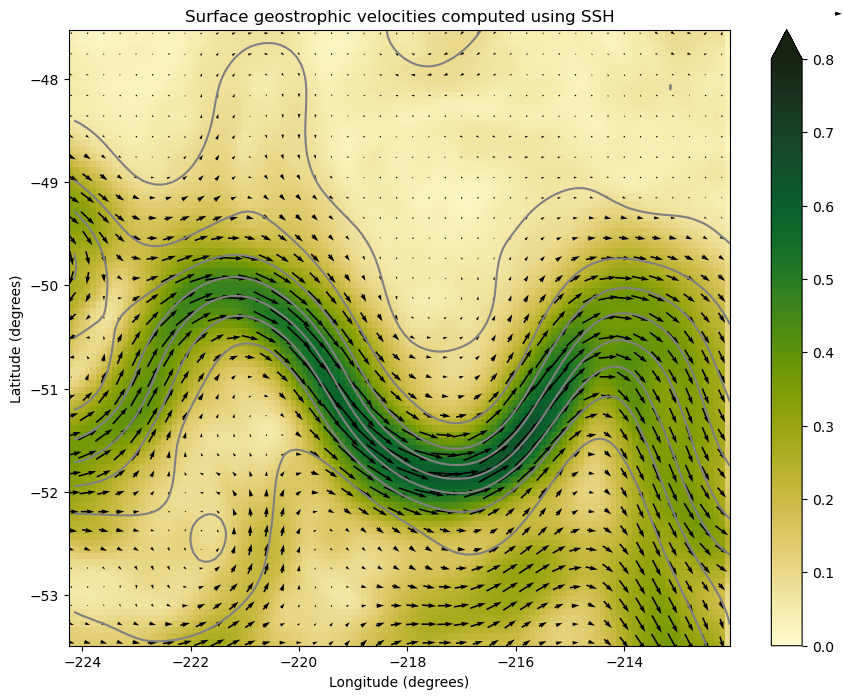

In [53]:
# to select every third cell
slc = xt_ocean = slice(None, None, 3)

Vg.mean('time').plot(size=8, cmap=cm.cm.speed, vmin=0, vmax=0.8, extend='max')
ds['sea_level'].mean('time').plot.contour(levels=np.linspace(-0.7, 0, 8), colors='gray', linestyles='solid')
ds.mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(x='xu_ocean', y='yu_ocean', u='ug_s', v='vg_s')

plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Surface geostrophic velocities computed using SSH');

We can compare the geostrophic velocities to the total simulated velocities at the surface and see what the difference in flow speed is. The difference is made up of the various contributions to the ageostrophic flow, such as the Ekman velocities and velocities driven by advection (curvature in the flow field).

In [54]:
# calculating the total flow speed from the simulated velocities at the surface
V_s = np.sqrt(ds['u']**2 + ds['v']**2)

ds['uag'] = ds['u'] - ds['ug_s']
ds['vag'] = ds['v'] - ds['vg_s']

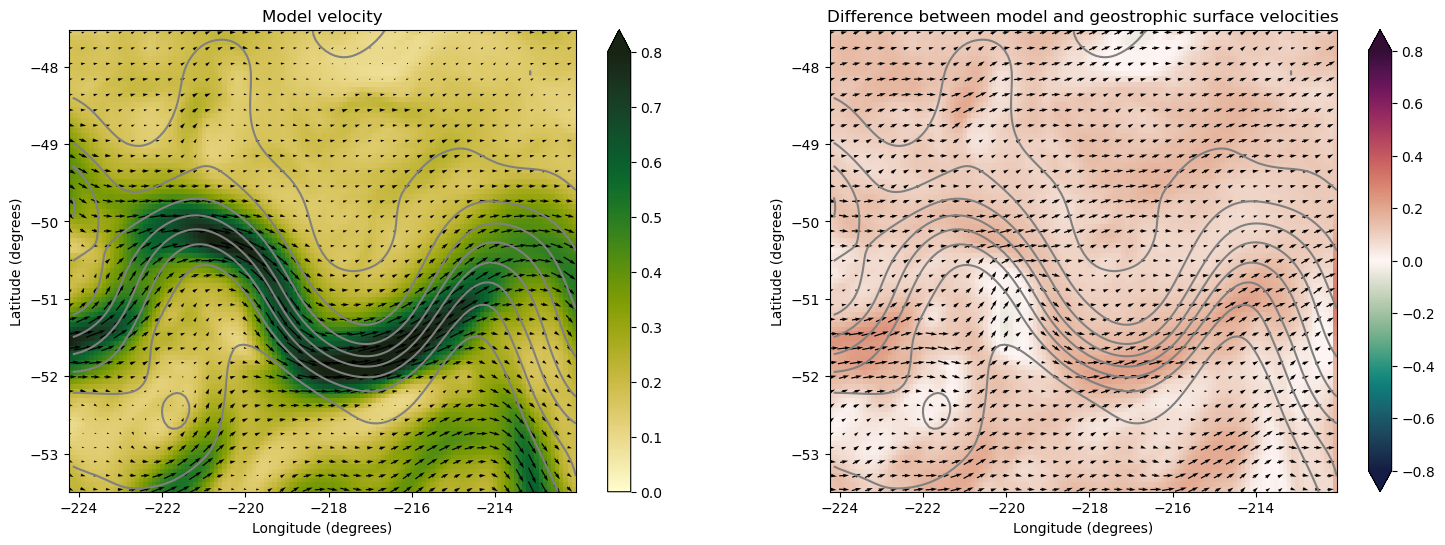

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Plot total flow speed
V_s.mean('time').plot(ax=axes[0], cmap=cm.cm.speed, vmin=0, vmax=0.8)

ds.mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(ax=axes[0],
                                                            x='xu_ocean', y='yu_ocean',
                                                            u='u', v='v',
                                                            add_guide = False)

# Plot ageostrophic flow speed
(V_s - Vg).mean('time').plot(ax=axes[1], cmap=cm.cm.curl, vmin=-0.8, vmax=0.8, extend='both')

ds.mean('time').sel(xu_ocean=slc, yu_ocean=slc).plot.quiver(ax=axes[1],
                                                             x='xu_ocean', y='yu_ocean',
                                                             u='uag', v='vag',
                                                             add_guide = False)

for ax in axes:
    ds['sea_level'].mean('time').plot.contour(ax=ax,
                                            levels=np.linspace(-0.7, 0, 8),
                                            colors='gray',
                                            linestyles='solid')
    ax.set_xlabel('Longitude (degrees)')
    ax.set_ylabel('Latitude (degrees)')

axes[0].set_title('Model velocity')
axes[1].set_title('Difference between model and geostrophic surface velocities');

It is interesting that the total flow speed is almost everywhere larger than the geostrophic flow speed due to the prevailing westerlies. However, where the streamlines are strongly curved agesotrophic velocities due to the advection (curvature) terms become important.

In [ ]:
client.close()